# Audio Clustering with Deep Learning Embeddings



## 1. Install and Import Libraries

In [1]:
# Install required libraries
!pip install librosa --quiet
!pip install soundfile --quiet
!pip install transformers --quiet
!pip install torch torchaudio --quiet
!pip install umap-learn --quiet
!pip install hdbscan --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set random seed and plotting style
np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')
print("Base libraries imported successfully!")

Base libraries imported successfully!


In [2]:
# Import audio processing libraries
import librosa
import librosa.display
import soundfile as sf
import torch
import torchaudio
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import umap
import hdbscan

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
print(f"Librosa version: {librosa.__version__}")

Using device: cpu
PyTorch version: 2.9.0+cu126
Librosa version: 0.11.0


## 2. Generate Synthetic Audio Data

Since we need audio files for clustering, we'll generate synthetic audio samples representing different categories.

In [3]:
def generate_synthetic_audio(category, duration=2.0, sr=16000):
    """
    Generate synthetic audio samples for different categories.

    Categories:
    - 'tone': Pure sine wave tones
    - 'noise': White/pink noise
    - 'chirp': Frequency sweeps
    - 'harmonics': Multi-harmonic sounds
    - 'pulse': Rhythmic pulses
    """
    t = np.linspace(0, duration, int(sr * duration), endpoint=False)

    if category == 'tone':
        # Pure sine wave with slight variations
        freq = np.random.uniform(200, 800)
        audio = np.sin(2 * np.pi * freq * t)
        audio *= 0.5  # Normalize

    elif category == 'noise':
        # Filtered noise
        audio = np.random.randn(len(t))
        # Simple low-pass filter effect
        filter_strength = np.random.uniform(0.8, 0.95)
        for i in range(1, len(audio)):
            audio[i] = filter_strength * audio[i-1] + (1-filter_strength) * audio[i]
        audio = audio / np.max(np.abs(audio)) * 0.5

    elif category == 'chirp':
        # Frequency sweep
        f0 = np.random.uniform(100, 300)
        f1 = np.random.uniform(800, 1500)
        phase = 2 * np.pi * (f0 * t + (f1 - f0) * t**2 / (2 * duration))
        audio = np.sin(phase)
        audio *= 0.5

    elif category == 'harmonics':
        # Multi-harmonic sound
        fundamental = np.random.uniform(150, 300)
        audio = np.zeros(len(t))
        for h in range(1, 6):
            amplitude = 1.0 / h
            audio += amplitude * np.sin(2 * np.pi * fundamental * h * t)
        audio = audio / np.max(np.abs(audio)) * 0.5

    elif category == 'pulse':
        # Rhythmic pulses
        rate = np.random.uniform(4, 10)  # pulses per second
        audio = np.zeros(len(t))
        pulse_freq = np.random.uniform(300, 600)
        for pulse_time in np.arange(0, duration, 1/rate):
            idx = int(pulse_time * sr)
            pulse_duration = int(0.05 * sr)  # 50ms pulse
            if idx + pulse_duration < len(audio):
                envelope = np.exp(-np.linspace(0, 5, pulse_duration))
                pulse_t = np.linspace(0, 0.05, pulse_duration)
                audio[idx:idx+pulse_duration] += envelope * np.sin(2 * np.pi * pulse_freq * pulse_t)
        audio = audio / np.max(np.abs(audio) + 1e-8) * 0.5

    # Add small amount of noise for realism
    audio += np.random.randn(len(audio)) * 0.01

    return audio.astype(np.float32)

# Generate samples
categories = ['tone', 'noise', 'chirp', 'harmonics', 'pulse']
n_samples_per_category = 20
sr = 16000
duration = 2.0

audio_samples = []
labels = []

for cat_idx, category in enumerate(categories):
    for _ in range(n_samples_per_category):
        audio = generate_synthetic_audio(category, duration, sr)
        audio_samples.append(audio)
        labels.append(cat_idx)

audio_samples = np.array(audio_samples)
y_true = np.array(labels)

print(f"Generated {len(audio_samples)} audio samples")
print(f"Categories: {categories}")
print(f"Samples per category: {n_samples_per_category}")
print(f"Sample rate: {sr} Hz")
print(f"Duration: {duration} seconds")

Generated 100 audio samples
Categories: ['tone', 'noise', 'chirp', 'harmonics', 'pulse']
Samples per category: 20
Sample rate: 16000 Hz
Duration: 2.0 seconds


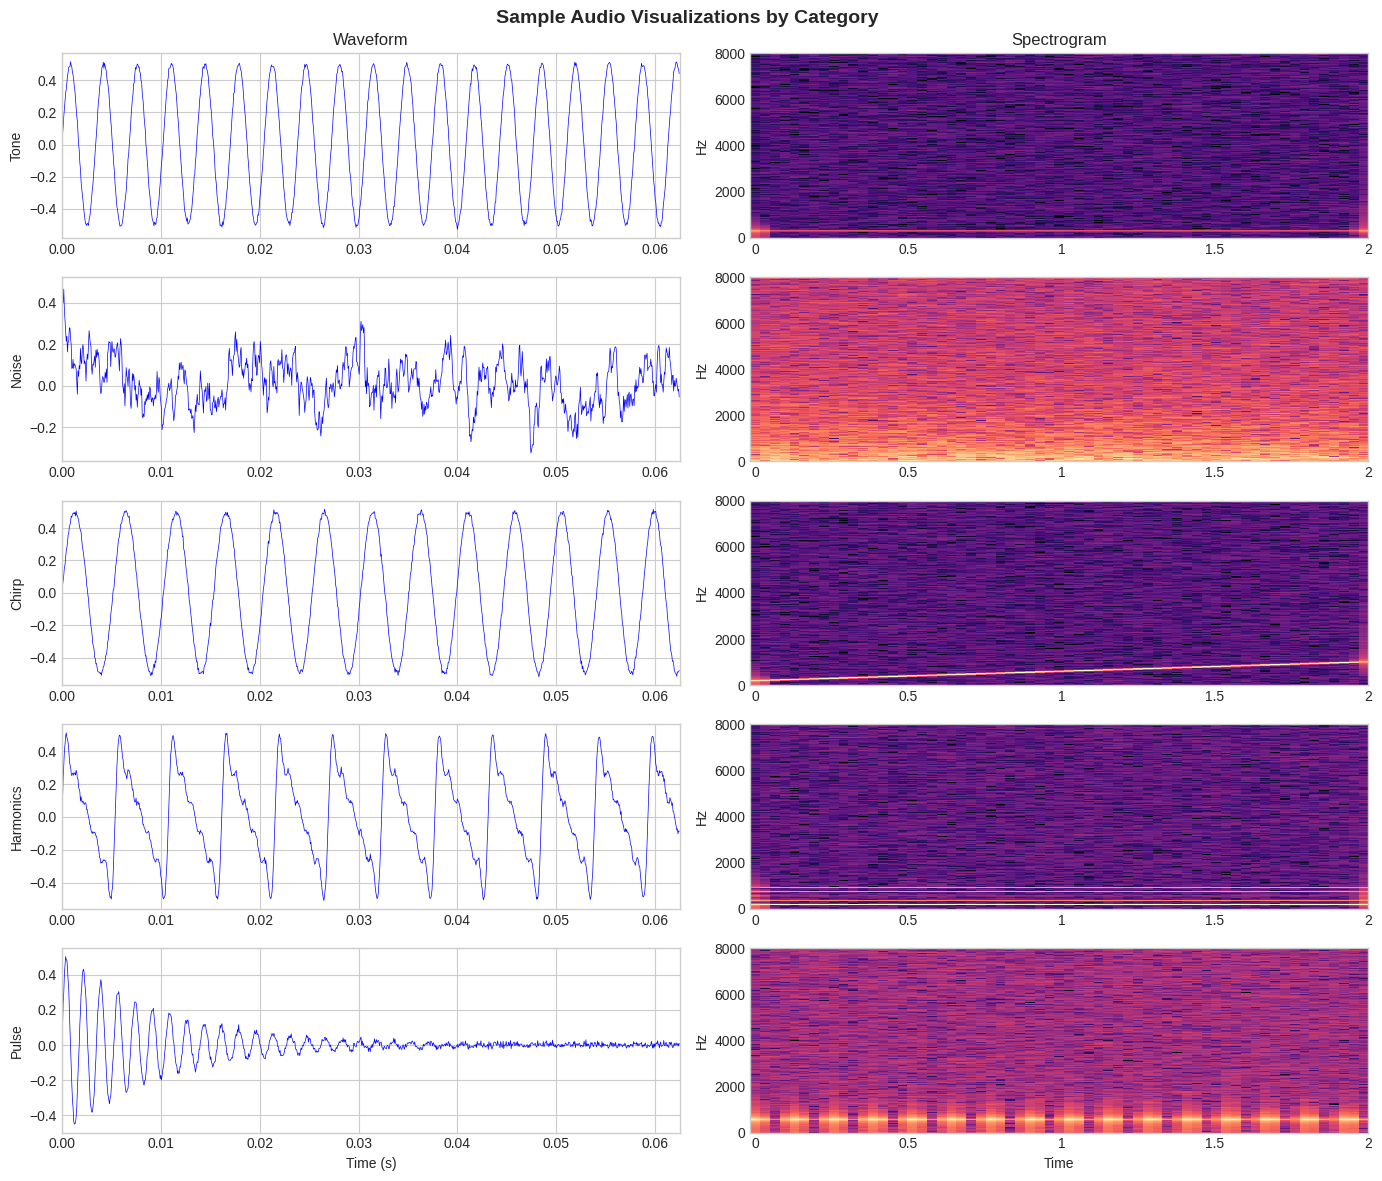

In [4]:
# Visualize sample waveforms from each category
fig, axes = plt.subplots(len(categories), 2, figsize=(14, 12))

for cat_idx, category in enumerate(categories):
    # Get first sample from this category
    sample_idx = cat_idx * n_samples_per_category
    audio = audio_samples[sample_idx]

    # Waveform
    t = np.linspace(0, duration, len(audio))
    axes[cat_idx, 0].plot(t[:1000], audio[:1000], 'b-', linewidth=0.5)
    axes[cat_idx, 0].set_ylabel(category.capitalize())
    axes[cat_idx, 0].set_xlim([0, t[1000]])
    if cat_idx == 0:
        axes[cat_idx, 0].set_title('Waveform')
    if cat_idx == len(categories) - 1:
        axes[cat_idx, 0].set_xlabel('Time (s)')

    # Spectrogram
    D = librosa.stft(audio)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', ax=axes[cat_idx, 1])
    if cat_idx == 0:
        axes[cat_idx, 1].set_title('Spectrogram')
    if cat_idx < len(categories) - 1:
        axes[cat_idx, 1].set_xlabel('')

plt.suptitle('Sample Audio Visualizations by Category', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3. Extract Traditional Audio Features (MFCCs)

In [5]:
def extract_mfcc_features(audio, sr, n_mfcc=13):
    """
    Extract MFCC features from audio.
    Returns mean and std of each MFCC coefficient.
    """
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfccs, axis=1)
    mfcc_std = np.std(mfccs, axis=1)
    return np.concatenate([mfcc_mean, mfcc_std])

def extract_spectral_features(audio, sr):
    """
    Extract spectral features from audio.
    """
    # Spectral centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)

    # Spectral bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)

    # Spectral rolloff
    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)

    # Zero crossing rate
    zcr = librosa.feature.zero_crossing_rate(audio)

    # RMS energy
    rms = librosa.feature.rms(y=audio)

    features = np.array([
        np.mean(spectral_centroid), np.std(spectral_centroid),
        np.mean(spectral_bandwidth), np.std(spectral_bandwidth),
        np.mean(spectral_rolloff), np.std(spectral_rolloff),
        np.mean(zcr), np.std(zcr),
        np.mean(rms), np.std(rms)
    ])

    return features

# Extract features for all samples
print("Extracting MFCC features...")
mfcc_features = np.array([extract_mfcc_features(audio, sr) for audio in audio_samples])
print(f"MFCC features shape: {mfcc_features.shape}")

print("\nExtracting spectral features...")
spectral_features = np.array([extract_spectral_features(audio, sr) for audio in audio_samples])
print(f"Spectral features shape: {spectral_features.shape}")

# Combine all traditional features
traditional_features = np.hstack([mfcc_features, spectral_features])
print(f"\nCombined traditional features shape: {traditional_features.shape}")

Extracting MFCC features...
MFCC features shape: (100, 26)

Extracting spectral features...
Spectral features shape: (100, 10)

Combined traditional features shape: (100, 36)


## 4. Extract Deep Learning Embeddings (Wav2Vec2)

In [ ]:
# Load Wav2Vec2 model
print("Loading Wav2Vec2 model...")
wav2vec_processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
wav2vec_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")
wav2vec_model = wav2vec_model.to(device)
wav2vec_model.eval()
print("Wav2Vec2 model loaded successfully!")

Loading Wav2Vec2 model...


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

In [ ]:
def get_wav2vec_embeddings(audio_samples, processor, model, device, sr=16000):
    """
    Extract Wav2Vec2 embeddings from audio samples.
    Returns mean-pooled embeddings.
    """
    embeddings = []

    for audio in audio_samples:
        # Process audio
        inputs = processor(audio, sampling_rate=sr, return_tensors="pt", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Get embeddings
        with torch.no_grad():
            outputs = model(**inputs)
            hidden_states = outputs.last_hidden_state

        # Mean pooling
        embedding = hidden_states.mean(dim=1).squeeze().cpu().numpy()
        embeddings.append(embedding)

    return np.array(embeddings)

# Extract embeddings
print("Extracting Wav2Vec2 embeddings (this may take a moment)...")
wav2vec_embeddings = get_wav2vec_embeddings(audio_samples, wav2vec_processor, wav2vec_model, device, sr)
print(f"Wav2Vec2 embeddings shape: {wav2vec_embeddings.shape}")

## 5. Visualize Embeddings

In [ ]:
# Normalize features
scaler_trad = StandardScaler()
traditional_features_scaled = scaler_trad.fit_transform(traditional_features)

scaler_wav2vec = StandardScaler()
wav2vec_embeddings_scaled = scaler_wav2vec.fit_transform(wav2vec_embeddings)

# UMAP reduction
print("Reducing dimensions with UMAP...")
umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)

traditional_2d = umap_reducer.fit_transform(traditional_features_scaled)
wav2vec_2d = umap_reducer.fit_transform(wav2vec_embeddings_scaled)

print("UMAP reduction complete!")

In [ ]:
# Visualize embeddings
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

colors = ['blue', 'red', 'green', 'orange', 'purple']

# Traditional features
for cat_idx, category in enumerate(categories):
    mask = y_true == cat_idx
    axes[0].scatter(traditional_2d[mask, 0], traditional_2d[mask, 1],
                    c=colors[cat_idx], label=category.capitalize(),
                    alpha=0.7, s=80, edgecolors='k')
axes[0].set_xlabel('UMAP Dimension 1')
axes[0].set_ylabel('UMAP Dimension 2')
axes[0].set_title('Traditional Features (MFCC + Spectral)')
axes[0].legend()

# Wav2Vec2 embeddings
for cat_idx, category in enumerate(categories):
    mask = y_true == cat_idx
    axes[1].scatter(wav2vec_2d[mask, 0], wav2vec_2d[mask, 1],
                    c=colors[cat_idx], label=category.capitalize(),
                    alpha=0.7, s=80, edgecolors='k')
axes[1].set_xlabel('UMAP Dimension 1')
axes[1].set_ylabel('UMAP Dimension 2')
axes[1].set_title('Wav2Vec2 Embeddings')
axes[1].legend()

plt.suptitle('Audio Embeddings Visualization (UMAP)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. K-Means Clustering

In [ ]:
# Apply K-Means to both feature sets
n_clusters = len(categories)

# Traditional features
kmeans_trad = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels_trad = kmeans_trad.fit_predict(traditional_features_scaled)

# Wav2Vec2 embeddings
kmeans_wav2vec = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels_wav2vec = kmeans_wav2vec.fit_predict(wav2vec_embeddings_scaled)

# Evaluate
def evaluate_clustering(features, labels_pred, y_true, method_name):
    ari = adjusted_rand_score(y_true, labels_pred)
    nmi = normalized_mutual_info_score(y_true, labels_pred)
    sil = silhouette_score(features, labels_pred)
    ch = calinski_harabasz_score(features, labels_pred)
    db = davies_bouldin_score(features, labels_pred)

    return {
        'Method': method_name,
        'ARI': ari,
        'NMI': nmi,
        'Silhouette': sil,
        'CH Index': ch,
        'DB Index': db
    }

results = []
results.append(evaluate_clustering(traditional_features_scaled, labels_trad, y_true, 'Traditional + K-Means'))
results.append(evaluate_clustering(wav2vec_embeddings_scaled, labels_wav2vec, y_true, 'Wav2Vec2 + K-Means'))

print("K-Means Clustering Results:")
print("="*80)
print(pd.DataFrame(results).to_string(index=False))

In [ ]:
# Visualize clustering results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Traditional + K-Means
scatter1 = axes[0].scatter(traditional_2d[:, 0], traditional_2d[:, 1],
                           c=labels_trad, cmap='viridis',
                           alpha=0.7, s=80, edgecolors='k')
axes[0].set_xlabel('UMAP Dimension 1')
axes[0].set_ylabel('UMAP Dimension 2')
axes[0].set_title(f'Traditional + K-Means\nARI: {results[0]["ARI"]:.3f}')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Wav2Vec2 + K-Means
scatter2 = axes[1].scatter(wav2vec_2d[:, 0], wav2vec_2d[:, 1],
                           c=labels_wav2vec, cmap='viridis',
                           alpha=0.7, s=80, edgecolors='k')
axes[1].set_xlabel('UMAP Dimension 1')
axes[1].set_ylabel('UMAP Dimension 2')
axes[1].set_title(f'Wav2Vec2 + K-Means\nARI: {results[1]["ARI"]:.3f}')
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

plt.suptitle('Audio Clustering Results', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Hierarchical Clustering

In [ ]:
# Apply Hierarchical Clustering
hclust_trad = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
labels_hclust_trad = hclust_trad.fit_predict(traditional_features_scaled)

hclust_wav2vec = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
labels_hclust_wav2vec = hclust_wav2vec.fit_predict(wav2vec_embeddings_scaled)

# Evaluate
results.append(evaluate_clustering(traditional_features_scaled, labels_hclust_trad, y_true, 'Traditional + Hierarchical'))
results.append(evaluate_clustering(wav2vec_embeddings_scaled, labels_hclust_wav2vec, y_true, 'Wav2Vec2 + Hierarchical'))

print("Hierarchical Clustering Results:")
print("="*80)
print(pd.DataFrame(results[2:]).to_string(index=False))

In [ ]:
# Create dendrogram for Wav2Vec2 embeddings
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(wav2vec_embeddings_scaled, method='ward')

plt.figure(figsize=(16, 8))

# Create labels
dendrogram_labels = [f"{categories[l]}_{i%n_samples_per_category}" for i, l in enumerate(y_true)]

dendrogram(Z, labels=dendrogram_labels, leaf_rotation=90, leaf_font_size=6,
           color_threshold=50)
plt.title('Hierarchical Clustering Dendrogram (Wav2Vec2 Embeddings)', fontsize=14, fontweight='bold')
plt.xlabel('Audio Sample')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

## 8. HDBSCAN Clustering

In [ ]:
# Apply HDBSCAN
hdbscan_trad = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=3)
labels_hdbscan_trad = hdbscan_trad.fit_predict(traditional_features_scaled)

hdbscan_wav2vec = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=3)
labels_hdbscan_wav2vec = hdbscan_wav2vec.fit_predict(wav2vec_embeddings_scaled)

print("HDBSCAN Results:")
print(f"Traditional - Clusters: {len(set(labels_hdbscan_trad)) - (1 if -1 in labels_hdbscan_trad else 0)}, Noise: {(labels_hdbscan_trad == -1).sum()}")
print(f"Wav2Vec2 - Clusters: {len(set(labels_hdbscan_wav2vec)) - (1 if -1 in labels_hdbscan_wav2vec else 0)}, Noise: {(labels_hdbscan_wav2vec == -1).sum()}")

## 9. Finding Optimal Number of Clusters

In [ ]:
# Elbow method and Silhouette analysis
k_range = range(2, 10)
inertias_trad = []
inertias_wav2vec = []
silhouettes_trad = []
silhouettes_wav2vec = []

for k in k_range:
    # Traditional
    km_trad = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km_trad.fit_predict(traditional_features_scaled)
    inertias_trad.append(km_trad.inertia_)
    silhouettes_trad.append(silhouette_score(traditional_features_scaled, labels))

    # Wav2Vec2
    km_wav = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km_wav.fit_predict(wav2vec_embeddings_scaled)
    inertias_wav2vec.append(km_wav.inertia_)
    silhouettes_wav2vec.append(silhouette_score(wav2vec_embeddings_scaled, labels))

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Elbow - Traditional
axes[0, 0].plot(k_range, inertias_trad, 'bo-', linewidth=2, markersize=8)
axes[0, 0].axvline(x=5, color='red', linestyle='--', label='K=5 (True)')
axes[0, 0].set_xlabel('Number of Clusters (K)')
axes[0, 0].set_ylabel('Inertia')
axes[0, 0].set_title('Elbow Method - Traditional Features')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Elbow - Wav2Vec2
axes[0, 1].plot(k_range, inertias_wav2vec, 'go-', linewidth=2, markersize=8)
axes[0, 1].axvline(x=5, color='red', linestyle='--', label='K=5 (True)')
axes[0, 1].set_xlabel('Number of Clusters (K)')
axes[0, 1].set_ylabel('Inertia')
axes[0, 1].set_title('Elbow Method - Wav2Vec2 Embeddings')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Silhouette - Traditional
axes[1, 0].plot(k_range, silhouettes_trad, 'bo-', linewidth=2, markersize=8)
axes[1, 0].axvline(x=5, color='red', linestyle='--', label='K=5 (True)')
axes[1, 0].set_xlabel('Number of Clusters (K)')
axes[1, 0].set_ylabel('Silhouette Score')
axes[1, 0].set_title('Silhouette Analysis - Traditional Features')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Silhouette - Wav2Vec2
axes[1, 1].plot(k_range, silhouettes_wav2vec, 'go-', linewidth=2, markersize=8)
axes[1, 1].axvline(x=5, color='red', linestyle='--', label='K=5 (True)')
axes[1, 1].set_xlabel('Number of Clusters (K)')
axes[1, 1].set_ylabel('Silhouette Score')
axes[1, 1].set_title('Silhouette Analysis - Wav2Vec2 Embeddings')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Optimal Number of Clusters Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Optimal K (Traditional) by Silhouette: {list(k_range)[np.argmax(silhouettes_trad)]}")
print(f"Optimal K (Wav2Vec2) by Silhouette: {list(k_range)[np.argmax(silhouettes_wav2vec)]}")

## 10. Confusion Matrix

In [ ]:
# Create confusion matrices
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Traditional
cm_trad = confusion_matrix(y_true, labels_trad)
sns.heatmap(cm_trad, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=range(n_clusters), yticklabels=[c.capitalize() for c in categories])
axes[0].set_xlabel('Predicted Cluster')
axes[0].set_ylabel('True Category')
axes[0].set_title('Traditional Features + K-Means')

# Wav2Vec2
cm_wav = confusion_matrix(y_true, labels_wav2vec)
sns.heatmap(cm_wav, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=range(n_clusters), yticklabels=[c.capitalize() for c in categories])
axes[1].set_xlabel('Predicted Cluster')
axes[1].set_ylabel('True Category')
axes[1].set_title('Wav2Vec2 + K-Means')

plt.suptitle('Confusion Matrices: Audio Categories vs Clusters', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 11. Results Summary

In [ ]:
# Comprehensive results
results_df = pd.DataFrame(results)

print("="*80)
print("AUDIO CLUSTERING RESULTS SUMMARY")
print("="*80)
print("\nAll Methods Comparison:")
print(results_df.to_string(index=False))

# Best method
best_method = results_df.loc[results_df['ARI'].idxmax()]
print(f"\nBest Method: {best_method['Method']}")
print(f"ARI: {best_method['ARI']:.4f}, NMI: {best_method['NMI']:.4f}")

In [ ]:
# Visualize comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(results_df))
width = 0.25

bars1 = ax.bar(x - width, results_df['ARI'], width, label='ARI', color='steelblue')
bars2 = ax.bar(x, results_df['NMI'], width, label='NMI', color='coral')
bars3 = ax.bar(x + width, results_df['Silhouette'], width, label='Silhouette', color='green')

ax.set_xlabel('Method')
ax.set_ylabel('Score')
ax.set_title('Audio Clustering Methods Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Method'], rotation=45, ha='right')
ax.legend()
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [ ]:
print("="*70)
print("AUDIO CLUSTERING WITH DEEP LEARNING EMBEDDINGS - SUMMARY")
print("="*70)

print("\n1. FEATURE EXTRACTION METHODS:")
print("   - Traditional: MFCCs (26 features) + Spectral features (10 features)")
print("   - Deep Learning: Wav2Vec2 embeddings (768 dimensions)")

print("\n2. CLUSTERING ALGORITHMS:")
print("   - K-Means: Partition-based clustering")
print("   - Hierarchical: Agglomerative with Ward linkage")
print("   - HDBSCAN: Density-based clustering")

print("\n3. QUALITY METRICS:")
print("   - Adjusted Rand Index (ARI): Agreement with ground truth")
print("   - Normalized Mutual Information (NMI): Information overlap")
print("   - Silhouette Score: Cluster cohesion and separation")
print("   - Calinski-Harabasz Index: Variance ratio criterion")
print("   - Davies-Bouldin Index: Cluster similarity measure")

print("\n4. DATASET:")
print(f"   - {len(audio_samples)} synthetic audio samples")
print(f"   - {len(categories)} categories: {', '.join([c.capitalize() for c in categories])}")
print(f"   - Sample rate: {sr} Hz, Duration: {duration} seconds")

print("\n5. KEY FINDINGS:")
print(f"   - Best method: {best_method['Method']}")
print("   - Deep learning embeddings capture complex acoustic patterns")
print("   - Traditional features work well for distinct audio types")
print("   - Wav2Vec2 provides rich semantic representations")

print("\n6. APPLICATIONS:")
print("   - Music genre classification")
print("   - Speaker diarization")
print("   - Sound event detection")
print("   - Audio content organization")

print("\n" + "="*70)